In [1]:
#import packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm



c:\users\jliu471\appdata\local\programs\python\python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='PS_error', ylabel='Density'>

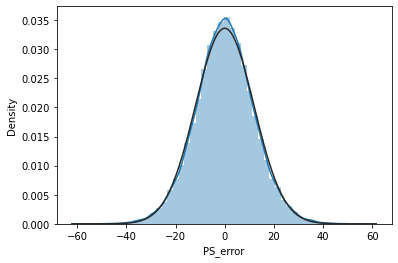

In [2]:
#set working directory
df = pd.read_csv('../predictions/predictions_20_22_test_game/all_before_20/feature_selection_LR_standard_prediction_train.csv')
#calculate errors
df["PS_error"] = df["pointspread"] - df["pointspread_pred"]
#calculate mean and standard deviation
mean = df["PS_error"].mean().round(3)
std = df["PS_error"].std().round(3)
# plot histogram
sns.distplot(df["PS_error"], fit=norm, kde=True)





(-35.22496337355588, 35.224963373555745)
(-23.263394984906224, 23.263394984906224)
(-19.523256507750244, 19.523256507750236)


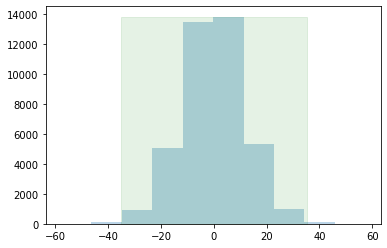

In [3]:
mu, sigma = np.mean(df['PS_error']), np.std(df['PS_error']) 
interval = norm.interval(0.997,loc=mu,scale=sigma) 
interval95 = norm.interval(0.95,loc=mu,scale=sigma) 
interval90 = norm.interval(0.90,loc=mu,scale=sigma) 
print(interval)
print(interval95)
print(interval90)
height, bins, patches = plt.hist(df['PS_error'], alpha=0.3)
plt.fill_betweenx([0, height.max()], interval[0], interval[1], color='g', alpha=0.1)

c:\users\jliu471\appdata\local\programs\python\python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='PS_error', ylabel='Density'>

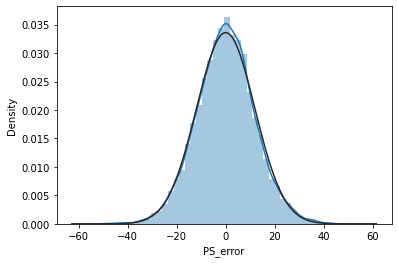

In [4]:
# home prediction
df_home = df[df['loc'] == 1]
# plot histogram
sns.distplot(df_home["PS_error"], fit=norm, kde=True)

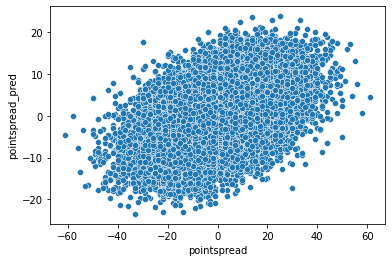

In [8]:
# point anomaly
sns.scatterplot(x=df["pointspread"], y=df["pointspread_pred"], data=df) 
plt.show()

In [3]:
# Define a function to calculate the rate of MAE above a threshold
def calc_rate(df, threshold):
    num_above = (df['PS_error'].abs() > threshold).sum()
    total = len(df)
    return num_above / total

In [5]:
team_map = {
    1610612737: 'ATL',
    1610612738: 'BOS',
    1610612740: 'NOP',
    1610612741: 'CHI',
    1610612742: 'DAL',
    1610612743: 'DEN',
    1610612745: 'HOU',
    1610612746: 'LAC',
    1610612747: 'LAL',
    1610612748: 'MIA',
    1610612749: 'MIL',
    1610612750: 'MIN',
    1610612751: 'BKN',
    1610612752: 'NYK',
    1610612753: 'ORL',
    1610612754: 'IND',
    1610612755: 'PHI',
    1610612756: 'PHX',
    1610612757: 'POR',
    1610612758: 'SAC',
    1610612759: 'SAS',
    1610612760: 'OKC',
    1610612761: 'TOR',
    1610612762: 'UTA',
    1610612763: 'MEM',
    1610612764: 'WAS',
    1610612765: 'DET',
    1610612766: 'CHA',
    1610612739: 'CLE',
    1610612744: 'GSW'
}

In [9]:
# Define a dictionary mapping team_id to team_name


# Group the data frame by team_id
grouped = df.groupby('team_id')

# Calculate the rates for all games
all_games_rates = grouped.apply(lambda x: pd.Series({
    '90%_all_game': calc_rate(x, 19),
    '95%_all_game': calc_rate(x, 23),
    '99%_all_game': calc_rate(x, 35),
}))

# Calculate the rates for regular season games
regular_rates = grouped.apply(lambda x: pd.Series({
    '90%_regular': calc_rate(x[x['GAME_ID'].astype(str).str.startswith('2')], 19),
    '95%_regular': calc_rate(x[x['GAME_ID'].astype(str).str.startswith('2')], 23),
    '99%_regular': calc_rate(x[x['GAME_ID'].astype(str).str.startswith('2')], 35),
}))

# Calculate the rates for post-season games
post_rates = grouped.apply(lambda x: pd.Series({
    '90%_post': calc_rate(x[x['GAME_ID'].astype(str).str.startswith('4')], 19),
    '95%_post': calc_rate(x[x['GAME_ID'].astype(str).str.startswith('4')], 23),
    '99%_post': calc_rate(x[x['GAME_ID'].astype(str).str.startswith('4')], 35),
}))

# Combine the results into a new data frame and replace team_id with team_name
result = pd.concat([all_games_rates, regular_rates, post_rates], axis=1)
result.index = result.index.map(team_map.get)
result.to_csv('team_anomaly_comparison_train.csv')

In [29]:
df_test = pd.read_csv('../predictions/predictions_20_22_test_game/all_before_20/feature_selection_LR_standard_prediction.csv')

In [31]:
df_test['MAE'] = abs(df_test['pointspread'] - df_test['pointspread_pred'])
# Convert GAME_DATE_EST to datetime format
df_test['GAME_DATE_EST'] = pd.to_datetime(df_test['GAME_DATE_EST'], format='%m/%d/%Y')

# Select all rows that GAME_ID column start with 4
df_test = df_test[df_test['GAME_ID'].astype(str).str.startswith('4')]

# Group each unique team_id and oppo_id pairs
unique_pairs = df_test.groupby(['team_id', 'oppo_id'])

# Create an empty DataFrame to store the results
team_anomaly_comparison = pd.DataFrame(index=[f'{team_map[k[0]]}vs{team_map[k[1]]}' for k in unique_pairs.groups.keys()], columns=['Game 1', 'Game 2', 'Game 3', 'Game 4', 'Game 5', 'Game 6', 'Game 7'])

# Loop through each unique pair
for pair, games in unique_pairs:
    # Get the index for this pair
    pair_index = f'{team_map[pair[0]]}vs{team_map[pair[1]]}'

    # Sort games by date
    games = games.sort_values(by='GAME_DATE_EST')

    # Rank each game
    games['Game Number'] = range(1, len(games) + 1)

    # Determine which games have a MAE greater than 19
    games['Anomaly'] = games['MAE'] > 19

    # Set the results in the team_anomaly_comparison DataFrame
    for i in range(1, 8):
        if i in games['Game Number'].values:
            team_anomaly_comparison.loc[pair_index, f'Game {i}'] = games[games['Game Number'] == i]['Anomaly'].values[0]
        else:
            team_anomaly_comparison.loc[pair_index, f'Game {i}'] = np.nan
team_anomaly_comparison

,Game 1,Game 2,Game 3,Game 4,Game 5,Game 6,Game 7
ATLvsMIA,True,False,False,True,False,NaN,NaN
BOSvsGSW,False,True,False,False,False,False,NaN
BOSvsMIA,False,True,False,False,False,False,False
BOSvsMIL,True,True,False,False,False,False,True
BOSvsBKN,False,False,False,False,NaN,NaN,NaN
NOPvsPHX,False,True,False,False,False,False,NaN
CHIvsMIL,False,False,True,True,False,NaN,NaN
DALvsGSW,True,False,False,False,False,NaN,NaN
DALvsPHX,False,False,False,False,True,True,True
DALvsUTA,False,False,False,False,False,False,NaN


In [34]:
# Count the number of True values in each column
count = team_anomaly_comparison.eq(True).sum()

# Calculate the true_percentage
true_percentage = (team_anomaly_comparison.eq(True).sum() / (team_anomaly_comparison.notnull().sum() - 2)) * 100

# Add count and true_percentage as new rows to the dataframe
team_anomaly_comparison.loc['count'] = count
team_anomaly_comparison.loc['true_percentage'] = true_percentage

# Print the updated dataframe
print(team_anomaly_comparison)

                    Game 1     Game 2 Game 3 Game 4     Game 5 Game 6  \
ATLvsMIA              True      False  False   True      False    NaN   
BOSvsGSW             False       True  False  False      False  False   
BOSvsMIA             False       True  False  False      False  False   
BOSvsMIL              True       True  False  False      False  False   
BOSvsBKN             False      False  False  False        NaN    NaN   
NOPvsPHX             False       True  False  False      False  False   
CHIvsMIL             False      False   True   True      False    NaN   
DALvsGSW              True      False  False  False      False    NaN   
DALvsPHX             False      False  False  False       True   True   
DALvsUTA             False      False  False  False      False  False   
DENvsGSW             False      False  False  False      False    NaN   
GSWvsBOS             False       True  False  False      False  False   
GSWvsDAL              True      False  False  False

In [33]:
team_anomaly_comparison.notnull().sum()

Game 1    32
Game 2    32
Game 3    32
Game 4    32
Game 5    30
Game 6    22
Game 7     8
dtype: int64

In [16]:
team_anomaly_comparison.to_csv('game_number_anomaly_comparison.csv')

In [35]:
df['MAE'] = abs(df['pointspread'] - df['pointspread_pred'])
# Convert GAME_DATE_EST to datetime format
df['GAME_DATE_EST'] = pd.to_datetime(df['GAME_DATE_EST'], format='%m/%d/%Y')

# Select all rows that GAME_ID column start with 4
df = df[df['GAME_ID'].astype(str).str.startswith('4')]

# Group each unique team_id and oppo_id pairs
unique_pairs = df.groupby(['team_id', 'oppo_id'])

# Create an empty DataFrame to store the results
team_anomaly_comparison = pd.DataFrame(index=[f'{team_map[k[0]]}vs{team_map[k[1]]}' for k in unique_pairs.groups.keys()], columns=['Game 1', 'Game 2', 'Game 3', 'Game 4', 'Game 5', 'Game 6', 'Game 7'])

# Loop through each unique pair
for pair, games in unique_pairs:
    # Get the index for this pair
    pair_index = f'{team_map[pair[0]]}vs{team_map[pair[1]]}'

    # Sort games by date
    games = games.sort_values(by='GAME_DATE_EST')

    # Rank each game
    games['Game Number'] = range(1, len(games) + 1)

    # Determine which games have a MAE greater than 19
    games['Anomaly'] = games['MAE'] > 19

    # Set the results in the team_anomaly_comparison DataFrame
    for i in range(1, 8):
        if i in games['Game Number'].values:
            team_anomaly_comparison.loc[pair_index, f'Game {i}'] = games[games['Game Number'] == i]['Anomaly'].values[0]
        else:
            team_anomaly_comparison.loc[pair_index, f'Game {i}'] = np.nan
team_anomaly_comparison

,Game 1,Game 2,Game 3,Game 4,Game 5,Game 6,Game 7
ATLvsBOS,False,False,False,False,False,False,False
ATLvsCLE,False,False,False,False,False,False,False
ATLvsCHI,True,False,False,True,False,False,NaN
ATLvsMIA,True,False,True,False,False,True,False
ATLvsMIL,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...
DETvsIND,False,False,False,True,True,False,False
DETvsPHI,False,False,False,False,False,False,False
DETvsSAS,False,False,False,True,False,False,False
CHAvsMIA,False,False,False,False,True,False,False


In [37]:
# Count the number of True values in each column
count = team_anomaly_comparison.eq(True).sum()

# Calculate the true_percentage
true_percentage = (team_anomaly_comparison.eq(True).sum() / (team_anomaly_comparison.notnull().sum() - 2)) * 100

# Add count and true_percentage as new rows to the dataframe
team_anomaly_comparison.loc['count'] = count
team_anomaly_comparison.loc['true_percentage'] = true_percentage

# Print the updated dataframe
team_anomaly_comparison

,Game 1,Game 2,Game 3,Game 4,Game 5,Game 6,Game 7
ATLvsBOS,False,False,False,False,False,False,False
ATLvsCLE,False,False,False,False,False,False,False
ATLvsCHI,True,False,False,True,False,False,NaN
ATLvsMIA,True,False,True,False,False,True,False
ATLvsMIL,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...
DETvsSAS,False,False,False,True,False,False,False
CHAvsMIA,False,False,False,False,True,False,False
CHAvsORL,False,False,False,False,NaN,NaN,NaN
count,30,28,41,34,24,20,26


In [38]:
team_anomaly_comparison.to_csv('game_number_anomaly_comparison_train.csv')

In [6]:

# Group the data frame by team_id
grouped = df.groupby('team_id')

# Calculate the rates for all games
all_games_rates = grouped.apply(lambda x: pd.Series({
    '90%_all_game_2022': calc_rate(x, 19),
    '95%_all_game_2022': calc_rate(x, 23),
    '99%_all_game_2022': calc_rate(x, 35),
}))

# Calculate the rates for regular season games
regular_rates = grouped.apply(lambda x: pd.Series({
    '90%_regular_2022': calc_rate(x[x['GAME_ID'].astype(str).str.startswith('2')], 19),
    '95%_regular_2022': calc_rate(x[x['GAME_ID'].astype(str).str.startswith('2')], 23),
    '99%_regular_2022': calc_rate(x[x['GAME_ID'].astype(str).str.startswith('2')], 35),
}))

# Calculate the rates for post-season games
post_rates = grouped.apply(lambda x: pd.Series({
    '90%_post_2022': calc_rate(x[x['GAME_ID'].astype(str).str.startswith('4')], 19),
    '95%_post_2022': calc_rate(x[x['GAME_ID'].astype(str).str.startswith('4')], 23),
    '99%_post_2022': calc_rate(x[x['GAME_ID'].astype(str).str.startswith('4')], 35),
}))

# Combine the results into a new data frame and replace team_id with team_name
result = pd.concat([all_games_rates, regular_rates, post_rates], axis=1)
result.index = result.index.map(team_map.get)
result


,90%_all_game_2022,95%_all_game_2022,99%_all_game_2022,90%_regular_2022,95%_regular_2022,99%_regular_2022,90%_post_2022,95%_post_2022,99%_post_2022
team_id,,,,,,,,,
ATL,0.114521,0.056886,0.007485,0.112540,0.056270,0.008039,0.141304,0.065217,0.000000
BOS,0.105974,0.052632,0.007112,0.100000,0.044355,0.005645,0.150602,0.114458,0.018072
CLE,0.126165,0.070251,0.006452,0.117458,0.063556,0.004827,0.197368,0.125000,0.019737
NOP,0.088441,0.045772,0.003879,0.085875,0.044944,0.003210,0.162791,0.069767,0.023256
CHI,0.130337,0.065169,0.008989,0.128617,0.066720,0.008842,0.153846,0.043956,0.010989
DAL,0.111439,0.051661,0.008856,0.111647,0.050602,0.009639,0.109091,0.063636,0.000000
DEN,0.114135,0.054422,0.005291,0.115663,0.054618,0.004819,0.089744,0.051282,0.012821
GSW,0.132417,0.063676,0.007959,0.127506,0.062550,0.008019,0.177778,0.074074,0.007407
HOU,0.108327,0.051584,0.005895,0.103531,0.044944,0.004815,0.162162,0.126126,0.018018


In [7]:
all_game = pd.Series({
    '90%_all_game_2022': calc_rate(df, 19),
    '95%_all_game_2022': calc_rate(df, 23),
    '99%_all_game_2022': calc_rate(df, 35),
})
regular = pd.Series({
    '90%_regular_2022': calc_rate(df[df['GAME_ID'].astype(str).str.startswith('2')], 19),
    '95%_regular_2022': calc_rate(df[df['GAME_ID'].astype(str).str.startswith('2')], 23),
    '99%_regular_2022': calc_rate(df[df['GAME_ID'].astype(str).str.startswith('2')], 35),
})
post = pd.Series({
    '90%_post_2022': calc_rate(df[df['GAME_ID'].astype(str).str.startswith('4')], 19),
    '95%_post_2022': calc_rate(df[df['GAME_ID'].astype(str).str.startswith('4')], 23),
    '99%_post_2022': calc_rate(df[df['GAME_ID'].astype(str).str.startswith('4')], 35),
})
result_no_team = pd.concat([all_game, regular, post], axis=1)
result_no_team

,0,1,2
90%_all_game_2022,0.109361,NaN,NaN
95%_all_game_2022,0.055469,NaN,NaN
99%_all_game_2022,0.005735,NaN,NaN
90%_regular_2022,NaN,0.108025,NaN
95%_regular_2022,NaN,0.054402,NaN
99%_regular_2022,NaN,0.005717,NaN
90%_post_2022,NaN,NaN,0.127994
95%_post_2022,NaN,NaN,0.070359
99%_post_2022,NaN,NaN,0.005988


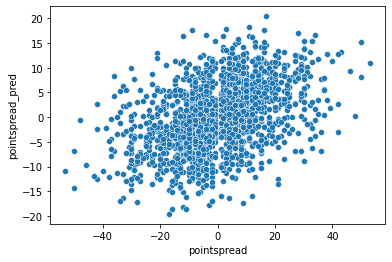

In [29]:
sns.scatterplot(x=df_test["pointspread"], y=df_test["pointspread_pred"], data=df_test) 
plt.show()

In [11]:
# Define X and y 
X = df_test['pointspread_pred']
y = df_test['pointspread']
df_test["PS_error"] = df_test["pointspread"] - df_test["pointspread_pred"]
play_offs = df_test[df_test['GAME_ID'].astype(str).str.startswith('4')].index
DALvsPHX = df_test.loc[df_test['GAME_ID'].isin([42100227, 42100226, 42100225, 42100224, 42100223, 42100222, 42100221])].index
GSWvsMEM = df_test.loc[df_test['GAME_ID'].isin([42100236, 42100235, 42100234, 42100233, 42100232, 42100231])].index
BOSvsMIA = df_test.loc[df_test['GAME_ID'].isin([42100307, 42100306, 42100305, 42100304, 42100303, 42100302, 42100301])].index








287


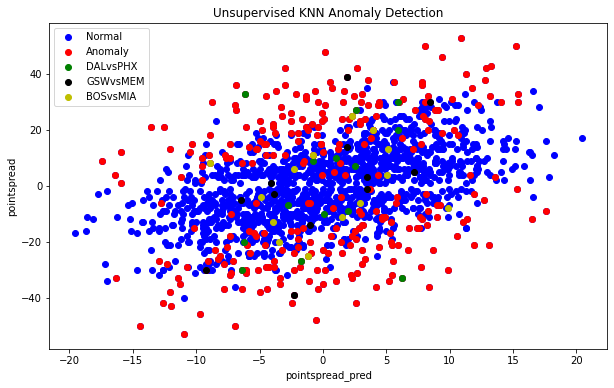

219


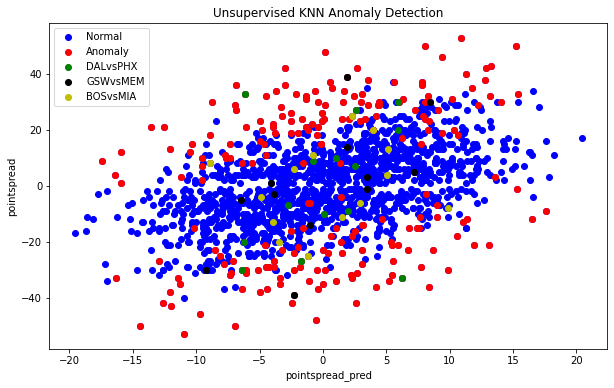

177


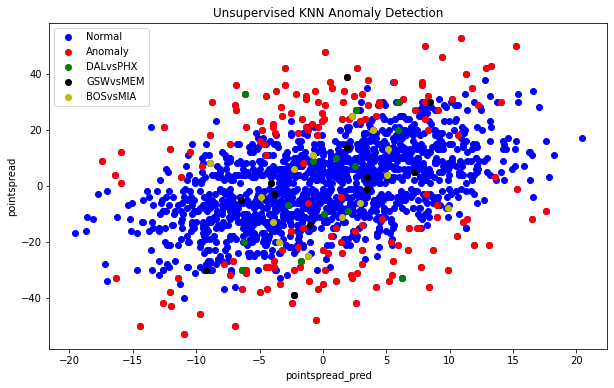

In [70]:
# Fit KNN model
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(n_neighbors=3, algorithm='ball_tree').fit(df_test["PS_error"].values.reshape(-1,1))
distances, indices = knn.kneighbors(df_test["PS_error"].values.reshape(-1,1))
for distance in [2, 2.5, 3]:
        # Define a threshold to classify points as anomalies
    threshold = distance * distances.mean()
    # Find anomalies
    anomalies = []
    for i in range(len(distances)):
        if distances[i].max() > threshold:
            anomalies.append(i)
    print(len(anomalies))
    # Create a scatter plot
    plt.figure(figsize=(10,6))
    plt.scatter(X, y, color='b', label='Normal')
    plt.scatter(X.iloc[anomalies], y.iloc[anomalies], color='r', label='Anomaly')
    plt.scatter(X.iloc[DALvsPHX], y.iloc[DALvsPHX], color='g', label='DALvsPHX')
    plt.scatter(X.iloc[GSWvsMEM], y.iloc[GSWvsMEM], color='k', label='GSWvsMEM')
    plt.scatter(X.iloc[BOSvsMIA], y.iloc[BOSvsMIA], color='y', label='BOSvsMIA')
    plt.xlabel('pointspread_pred')
    plt.ylabel('pointspread')
    plt.legend()
    plt.title('Unsupervised KNN Anomaly Detection')
    plt.show()

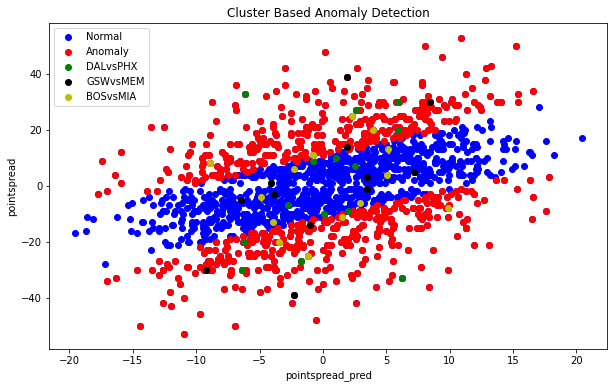

In [71]:
from sklearn.cluster import KMeans

# Generate sample data
XY = df_test["PS_error"]
XY = XY.to_numpy()
# Fit KMeans with X
kmeans = KMeans(n_clusters=1, random_state=0).fit(XY.reshape(-1,1))

# Get cluster labels
labels = kmeans.labels_

# Get cluster centers
centroids = kmeans.cluster_centers_

# Calculate the distances between each data point and its nearest cluster center
distances = np.zeros(XY.shape[0])
for i in range(XY.shape[0]):
    distances[i] = np.linalg.norm(XY[i]-centroids[labels[i]])

# Calculate the average distance for each cluster
avg_distances = np.zeros(len(centroids))
for label in range(len(centroids)):
    avg_distances[label] = np.mean(distances[labels==label])

# Find data points with distances greater than the average for their cluster
anomaly_indices = np.where(distances > avg_distances[labels])[0]

# Print out the indices of the anomalies
# Create a scatter plot
plt.figure(figsize=(10,6))
plt.scatter(X, y, color='b', label='Normal')
plt.scatter(X.iloc[anomaly_indices], y.iloc[anomaly_indices], color='r', label='Anomaly')
plt.scatter(X.iloc[DALvsPHX], y.iloc[DALvsPHX], color='g', label='DALvsPHX')
plt.scatter(X.iloc[GSWvsMEM], y.iloc[GSWvsMEM], color='k', label='GSWvsMEM')
plt.scatter(X.iloc[BOSvsMIA], y.iloc[BOSvsMIA], color='y', label='BOSvsMIA')
plt.xlabel('pointspread_pred')
plt.ylabel('pointspread')
plt.legend()
plt.title('Cluster Based Anomaly Detection')
plt.show()

In [12]:
# Contextual attributes – time: plot the mean absolute error each day and check if errors are bigger during play-offs.
df_test['MAE'] = abs(df_test['pointspread'] - df_test['pointspread_pred'])
df_test.head()

,GAME_ID,GAME_DATE_EST,team_id,oppo_id,PTS_team,pointspread,loc,PTS_team_pred,PTS_oppo_pred,pointspread_pred_from_pts,pointspread_pred,PS_error,MAE
0,22101229,4/10/2022,1610612758,1610612756,116,7,0,109.903217,119.506040,-9.602824,-9.509628,16.509628,16.509628
1,22101212,4/9/2022,1610612758,1610612746,98,-19,0,109.353778,117.309376,-7.955598,-8.921106,-10.078894,10.078894
2,22101188,4/5/2022,1610612758,1610612740,109,-14,1,108.428952,112.876622,-4.447670,-4.349185,-9.650815,9.650815
3,22101176,4/3/2022,1610612758,1610612744,90,-19,1,110.030848,113.356834,-3.325986,-3.122529,-15.877471,15.877471
4,22101154,4/1/2022,1610612758,1610612745,122,5,0,118.537603,115.893457,2.644146,1.733559,3.266441,3.266441


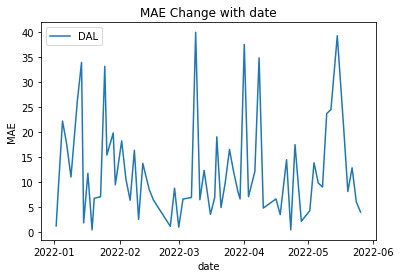

In [81]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from datetime import datetime

df_test['date'] = pd.to_datetime(df_test['GAME_DATE_EST'], format='%m/%d/%Y')
#dictionary = {'DAL': 1610612742, 'MIA': 1610612748, 'PHX':1610612756,'GSW': 1610612744, 'MEM': 1610612763, 'BOS': 1610612738}
dictionary = {'DAL': 1610612742}
for key, value in dictionary.items():
    x = df_test[df_test['team_id'] == value]["date"]
    y = df_test[df_test['team_id'] == value]["MAE"]
    plt.plot(x, y, label=key)
plt.legend()
plt.xlabel("date")
plt.ylabel("MAE")
plt.title("MAE Change with date")
plt.show()

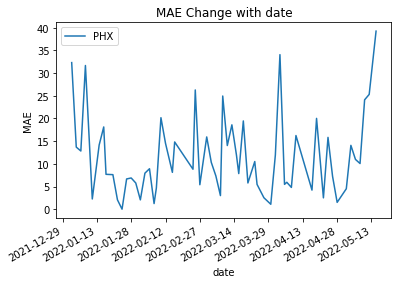

In [83]:
dictionary = {'PHX':1610612756}
for key, value in dictionary.items():
    x = df_test[df_test['team_id'] == value]["date"]
    y = df_test[df_test['team_id'] == value]["MAE"]
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=15))
    plt.plot(x, y, label=key)
plt.gcf().autofmt_xdate()
plt.legend()
plt.xlabel("date")
plt.ylabel("MAE")
plt.title("MAE Change with date")
plt.show()

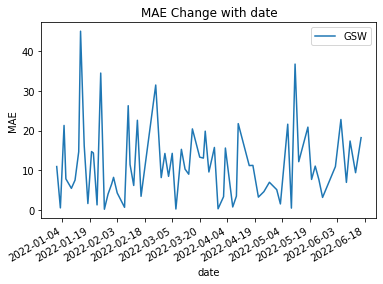

In [84]:
dictionary = {'GSW': 1610612744}
for key, value in dictionary.items():
    x = df_test[df_test['team_id'] == value]["date"]
    y = df_test[df_test['team_id'] == value]["MAE"]
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=15))
    plt.plot(x, y, label=key)
plt.gcf().autofmt_xdate()
plt.legend()
plt.xlabel("date")
plt.ylabel("MAE")
plt.title("MAE Change with date")
plt.show()

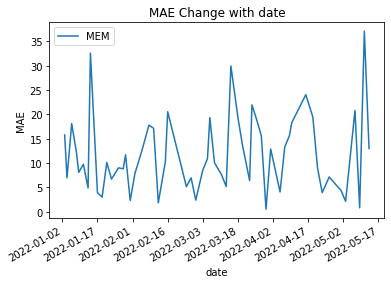

In [85]:
dictionary = {'MEM': 1610612763}
for key, value in dictionary.items():
    x = df_test[df_test['team_id'] == value]["date"]
    y = df_test[df_test['team_id'] == value]["MAE"]
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=15))
    plt.plot(x, y, label=key)
plt.gcf().autofmt_xdate()
plt.legend()
plt.xlabel("date")
plt.ylabel("MAE")
plt.title("MAE Change with date")
plt.show()

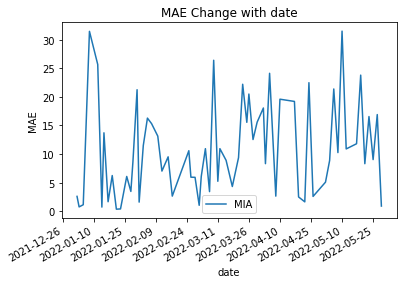

In [86]:
dictionary = {'MIA': 1610612748}
for key, value in dictionary.items():
    x = df_test[df_test['team_id'] == value]["date"]
    y = df_test[df_test['team_id'] == value]["MAE"]
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=15))
    plt.plot(x, y, label=key)
plt.gcf().autofmt_xdate()
plt.legend()
plt.xlabel("date")
plt.ylabel("MAE")
plt.title("MAE Change with date")
plt.show()

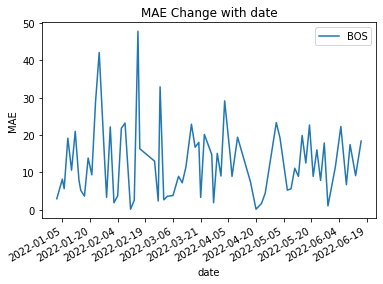

In [87]:
dictionary = {'BOS': 1610612738}
for key, value in dictionary.items():
    x = df_test[df_test['team_id'] == value]["date"]
    y = df_test[df_test['team_id'] == value]["MAE"]
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=15))
    plt.plot(x, y, label=key)
plt.gcf().autofmt_xdate()
plt.legend()
plt.xlabel("date")
plt.ylabel("MAE")
plt.title("MAE Change with date")
plt.show()

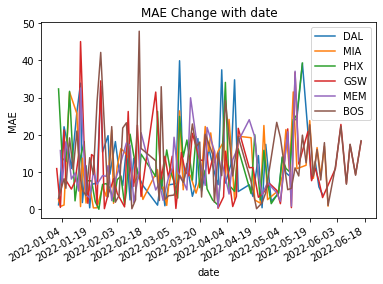

In [88]:
dictionary = {'DAL': 1610612742, 'MIA': 1610612748, 'PHX':1610612756,'GSW': 1610612744, 'MEM': 1610612763, 'BOS': 1610612738}
for key, value in dictionary.items():
    x = df_test[df_test['team_id'] == value]["date"]
    y = df_test[df_test['team_id'] == value]["MAE"]
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=15))
    plt.plot(x, y, label=key)
plt.gcf().autofmt_xdate()
plt.legend()
plt.xlabel("date")
plt.ylabel("MAE")
plt.title("MAE Change with date")
plt.show()

In [163]:
# get errors for these series of games
# 99.7%: (-35.22496337355588, 35.224963373555745)
# 95%: (-23.263394984906224, 23.263394984906224)
# 90%: (-19.523256507750244, 19.523256507750236)
DALvsPHX_errors = df_test.loc[df_test['GAME_ID'].isin([42100227, 42100226, 42100225, 42100224, 42100223, 42100222, 42100221])]
GSWvsMEM_errors = df_test.loc[df_test['GAME_ID'].isin([42100236, 42100235, 42100234, 42100233, 42100232, 42100231])]
BOSvsMIA_errors = df_test.loc[df_test['GAME_ID'].isin([42100307, 42100306, 42100305, 42100304, 42100303, 42100302, 42100301])]
print(f'DALvsPHX_errors: {DALvsPHX_errors}')
# DALvsPHX 1/7 out 99.7%
# DALvsPHX 3/7 out 95%
# DALvsPHX 3/7 out 90%
print(f'GSWvsMEM_errors: {GSWvsMEM_errors}')
# GSWvsMEM 1/7 out 99.7%
# GSWvsMEM 1/7 out 95%
# GSWvsMEM 2/7 out 90%
print(f'BOSvsMIA_errors: {BOSvsMIA_errors}')
# BOSvsMIA 0/7 out 99.7%
# BOSvsMIA 1/7 out 95%
# BOSvsMIA 1/7 out 90%

DALvsPHX_errors:        GAME_ID GAME_DATE_EST     team_id     oppo_id  PTS_team  pointspread  \
1263  42100227     5/15/2022  1610612756  1610612742        90          -33   
1264  42100226     5/12/2022  1610612756  1610612742        86          -27   
1265  42100225     5/10/2022  1610612756  1610612742       110           30   
1266  42100224      5/8/2022  1610612756  1610612742       101          -10   
1267  42100223      5/6/2022  1610612756  1610612742        94           -9   
1268  42100222      5/4/2022  1610612756  1610612742       129           20   
1269  42100221      5/2/2022  1610612756  1610612742       121            7   
1328  42100227     5/15/2022  1610612742  1610612756       123           33   
1329  42100226     5/12/2022  1610612742  1610612756       113           27   
1330  42100225     5/10/2022  1610612742  1610612756        80          -30   
1331  42100224      5/8/2022  1610612742  1610612756       111           10   
1332  42100223      5/6/2022  16106

In [101]:
inter99 = df_test[(abs(df_test['PS_error']) > 19) & (df_test['GAME_ID'].astype(str).str.startswith('4'))]
inter99
# DALvsPHX 3/7 out 90%
# BOS vs MIL: 3/7 out 90% 1/6 out 95%
# GSW vs MEM: 2/6 out 90%
# MIA vs ALT: 2/5 out 90% 0/6 out 95%
# MIA vs PHI: 2/6 out 90% 1/6 out 95%
# PHI vs TOR: 2/6 out 90% 1/6 out 95% 1/6 out 99.7%
# MEM vs MIN: 2/6 out 90% 1/6 out 95% 
# CHI vs MIL: 2/5 out 90% 1/5 out 95%

,GAME_ID,GAME_DATE_EST,team_id,oppo_id,PTS_team,pointspread,loc,PTS_team_pred,PTS_oppo_pred,pointspread_pred_from_pts,pointspread_pred,PS_error,MAE,date
657,42100104,4/24/2022,1610612737,1610612748,86,-24,1,110.578606,113.381532,-2.802926,-0.944598,-23.055402,23.055402,2022-04-24
660,42100101,4/17/2022,1610612737,1610612748,91,-24,0,111.599738,113.564654,-1.964917,-3.460577,-20.539423,20.539423,2022-04-17
765,42100124,4/24/2022,1610612741,1610612749,95,-24,1,107.157259,114.452204,-7.294944,-4.741760,-19.258240,19.258240,2022-04-24
766,42100123,4/22/2022,1610612741,1610612749,81,-30,1,111.266849,115.406727,-4.139878,-2.306677,-27.693323,27.693323,2022-04-22
873,42100175,4/25/2022,1610612762,1610612742,77,-25,0,105.811400,108.463272,-2.651873,-5.415086,-19.584914,19.584914,2022-04-25
929,42100142,4/19/2022,1610612740,1610612756,125,11,0,107.287776,113.400879,-6.113104,-9.296576,20.296576,20.296576,2022-04-19
980,42100136,4/28/2022,1610612761,1610612755,97,-35,1,103.533234,105.317217,-1.783983,0.041350,-35.041350,35.041350,2022-04-28
981,42100135,4/25/2022,1610612761,1610612755,103,15,0,105.241914,109.513194,-4.271280,-6.647359,21.647359,21.647359,2022-04-25
1040,42100152,4/19/2022,1610612750,1610612763,96,-28,0,118.588266,124.002297,-5.414031,-8.960052,-19.039948,19.039948,2022-04-19
1041,42100151,4/16/2022,1610612750,1610612763,130,13,0,115.880861,123.628015,-7.747153,-12.068192,25.068192,25.068192,2022-04-16


In [104]:
#  Discordancy test
# set threshold for Discordancy test 
threshold = 4 * sigma
# loop through data points and identify outliers 
for point in df_test['PS_error']: 
    if point < (mu - threshold) or point > (mu + threshold): 
        print('Anomalous data point: ', point)
ano_discordancy = df_test[abs(df_test['PS_error']) > threshold]
ano_discordancy

Anomalous data point:  -47.4816637491942
Anomalous data point:  47.81689473408702


,GAME_ID,GAME_DATE_EST,team_id,oppo_id,PTS_team,pointspread,loc,PTS_team_pred,PTS_oppo_pred,pointspread_pred_from_pts,pointspread_pred,PS_error,MAE,date
1184,22100869,2/15/2022,1610612755,1610612738,87,-48,1,104.332409,106.959597,-2.627188,-0.518336,-47.481664,47.481664,2022-02-15
1569,22100869,2/15/2022,1610612738,1610612755,135,48,0,106.959597,104.332409,2.627188,0.183105,47.816895,47.816895,2022-02-15


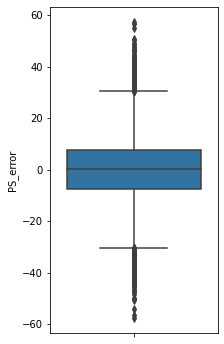

In [108]:
# Box Plot
plt.figure(figsize = (3, 6))
sns.boxplot(y=df['PS_error']);


In [107]:
q1 = np.percentile(df['PS_error'], 25)
q2 = np.percentile(df['PS_error'], 50)
q3 = np.percentile(df['PS_error'], 75)
iqr = q3 - q1
whisk1 = q1 - 1.5*iqr
whisk2 = q3 + 1.5*iqr

whisk1, q1, q2, q3, whisk2

(-30.53525784351998,
 -7.6406189818229375,
 0.033477737518299744,
 7.622473592641757,
 30.5171124543388)

In [110]:
ano_box = df_test[(abs(df_test['PS_error']) > whisk2) & (df_test['GAME_ID'].astype(str).str.startswith('4'))]
ano_box

,GAME_ID,GAME_DATE_EST,team_id,oppo_id,PTS_team,pointspread,loc,PTS_team_pred,PTS_oppo_pred,pointspread_pred_from_pts,pointspread_pred,PS_error,MAE,date
980,42100136,4/28/2022,1610612761,1610612755,97,-35,1,103.533234,105.317217,-1.783983,0.041350,-35.041350,35.041350,2022-04-28
1091,42100235,5/11/2022,1610612763,1610612744,134,39,1,111.166852,110.828443,0.338409,1.929794,37.070206,37.070206,2022-05-11
1148,42100205,5/10/2022,1610612755,1610612748,85,-35,0,104.623772,108.191947,-3.568175,-3.381416,-31.618584,31.618584,2022-05-10
1153,42100136,4/28/2022,1610612755,1610612761,132,35,0,105.317217,103.533234,1.783983,0.683183,34.316817,34.316817,2022-04-28
1263,42100227,5/15/2022,1610612756,1610612742,90,-33,1,107.859446,101.955761,5.903685,6.249964,-39.249964,39.249964,2022-05-15
1328,42100227,5/15/2022,1610612742,1610612756,123,33,0,101.955761,107.859446,-5.903685,-6.189750,39.189750,39.189750,2022-05-15
1396,42100205,5/10/2022,1610612748,1610612755,120,35,1,108.191947,104.623772,3.568175,3.487569,31.512431,31.512431,2022-05-10
1464,42100235,5/11/2022,1610612744,1610612763,95,-39,0,110.828443,111.166852,-0.338409,-2.258372,-36.741628,36.741628,2022-05-11


In [115]:
# Grubb’s test
import scipy.stats as stats

#Calculate the z-scores for each value in the PS_Error column
z_scores = stats.zscore(df_test['PS_error'])

#Calculate the critical value of Grubb's test
critical_value = stats.norm.ppf(1 - 0.05/2)

#Detect anomalies using Grubb's test
anomalies = []
for index, z_score in enumerate(z_scores):
    if abs(z_score) > critical_value:
        anomalies.append(index)

ano_grub = df_test.iloc[anomalies]
ano_grub[ano_grub['GAME_ID'].astype(str).str.startswith('4')]

,GAME_ID,GAME_DATE_EST,team_id,oppo_id,PTS_team,pointspread,loc,PTS_team_pred,PTS_oppo_pred,pointspread_pred_from_pts,pointspread_pred,PS_error,MAE,date
980,42100136,4/28/2022,1610612761,1610612755,97,-35,1,103.533234,105.317217,-1.783983,0.041350,-35.041350,35.041350,2022-04-28
1091,42100235,5/11/2022,1610612763,1610612744,134,39,1,111.166852,110.828443,0.338409,1.929794,37.070206,37.070206,2022-05-11
1148,42100205,5/10/2022,1610612755,1610612748,85,-35,0,104.623772,108.191947,-3.568175,-3.381416,-31.618584,31.618584,2022-05-10
1153,42100136,4/28/2022,1610612755,1610612761,132,35,0,105.317217,103.533234,1.783983,0.683183,34.316817,34.316817,2022-04-28
1263,42100227,5/15/2022,1610612756,1610612742,90,-33,1,107.859446,101.955761,5.903685,6.249964,-39.249964,39.249964,2022-05-15
1328,42100227,5/15/2022,1610612742,1610612756,123,33,0,101.955761,107.859446,-5.903685,-6.189750,39.189750,39.189750,2022-05-15
1396,42100205,5/10/2022,1610612748,1610612755,120,35,1,108.191947,104.623772,3.568175,3.487569,31.512431,31.512431,2022-05-10
1464,42100235,5/11/2022,1610612744,1610612763,95,-39,0,110.828443,111.166852,-0.338409,-2.258372,-36.741628,36.741628,2022-05-11


In [116]:
# find who is responsible for this.
players = pd.read_csv('../predictions/predictions_all_test_player/feature_selection_LR_standard_prediction.csv')
players

,GAME_DATE_EST,GAME_ID,HOME_TEAM_ID,OPPO_ID,PLAYER_ID,PLAYER_NAME,PLUS_MINUS,PLUS_MINUS_pred,PTS,PTS_pred,...,START_POSITION_C,START_POSITION_F,START_POSITION_G,TEAM_ABBREVIATION,TEAM_CITY,TEAM_ID,loc,season_Pos,season_Pre,season_Reg
0,6/16/2022,42100406,1610612738,1610612738,203952,Andrew Wiggins,5,-1.204702,18,18.064124,...,0,1,0,GSW,Golden State,1610612744,0,1,0,0
1,6/16/2022,42100406,1610612738,1610612738,203490,Otto Porter Jr.,3,-1.650015,6,5.538733,...,0,1,0,GSW,Golden State,1610612744,0,1,0,0
2,6/16/2022,42100406,1610612738,1610612738,203110,Draymond Green,16,-1.532827,12,7.282874,...,1,0,0,GSW,Golden State,1610612744,0,1,0,0
3,6/16/2022,42100406,1610612738,1610612738,202691,Klay Thompson,4,-3.860952,12,19.585608,...,0,0,1,GSW,Golden State,1610612744,0,1,0,0
4,6/16/2022,42100406,1610612738,1610612738,201939,Stephen Curry,8,-1.251577,34,26.823889,...,0,0,1,GSW,Golden State,1610612744,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
432273,4/17/2004,40300101,1610612754,1610612754,1088,Chucky Atkins,-13,-3.841762,19,9.708468,...,0,0,1,BOS,Boston,1610612738,0,1,0,0
432274,4/17/2004,40300101,1610612754,1610612754,1729,Ricky Davis,-3,-1.963244,19,14.592519,...,0,0,0,BOS,Boston,1610612738,0,1,0,0
432275,4/17/2004,40300101,1610612754,1610612754,2036,Chris Mihm,-1,-2.261462,9,2.879371,...,0,0,0,BOS,Boston,1610612738,0,1,0,0
432276,4/17/2004,40300101,1610612754,1610612754,2556,Marcus Banks,-3,-2.017863,2,7.734450,...,0,0,0,BOS,Boston,1610612738,0,1,0,0


In [154]:
players['pts_errors'] = players['PTS'] - players['PTS_pred']
mu_player_pts, sigma_player_pts = np.mean(players['pts_errors']), np.std(players['pts_errors']) 
interval99_player_pts = norm.interval(0.99,loc=mu_player_pts,scale=sigma_player_pts) 
interval95_player_pts = norm.interval(0.95,loc=mu_player_pts,scale=sigma_player_pts) 
interval90_player_pts = norm.interval(0.90,loc=mu_player_pts,scale=sigma_player_pts) 
print(mu_player_pts, sigma_player_pts)
print(interval99_player_pts)
print(interval95_player_pts)
print(interval90_player_pts)

9.646399190089897e-05 5.6593223754937005
(-14.577351949034748, 14.577544877018548)
(-11.091971568877417, 11.092164496861217)
(-9.308660471426538, 9.308853399410335)


In [153]:
players['PLUS_MINUS_errors'] = players['PLUS_MINUS'] - players['PLUS_MINUS_pred']
mu_player_ps, sigma_player_ps = np.mean(players['PLUS_MINUS_errors']), np.std(players['PLUS_MINUS_errors']) 
interval99_player_ps = norm.interval(0.99,loc=mu_player_ps,scale=sigma_player_ps) 
interval95_player_ps = norm.interval(0.95,loc=mu_player_ps,scale=sigma_player_ps) 
interval90_player_ps = norm.interval(0.90,loc=mu_player_ps,scale=sigma_player_ps) 
print(mu_player_ps, sigma_player_ps)
print(interval99_player_ps)
print(interval95_player_ps)
print(interval90_player_ps)

-0.0013602517075496344 10.402444764078002
(-26.796282303568493, 26.793561800153395)
(-20.389777340467692, 20.387056837052594)
(-17.11185925106361, 17.109138747648505)


In [122]:
DALvsPHX_players_errors = players.loc[players['GAME_ID'].isin([42100227, 42100226, 42100225, 42100224, 42100223, 42100222, 42100221])]
DALvsPHX_players_errors

,GAME_DATE_EST,GAME_ID,HOME_TEAM_ID,OPPO_ID,PLAYER_ID,PLAYER_NAME,PLUS_MINUS,PLUS_MINUS_pred,PTS,PTS_pred,...,START_POSITION_G,TEAM_ABBREVIATION,TEAM_CITY,TEAM_ID,loc,season_Pos,season_Pre,season_Reg,pts_errors,PLUS_MINUS_errors
390,5/15/2022,42100227,1610612756,1610612742,1628969,Mikal Bridges,-40,3.256235,6,13.114905,...,0,PHX,Phoenix,1610612756,1,1,0,0,-7.114905,-43.256235
391,5/15/2022,42100227,1610612756,1610612742,203109,Jae Crowder,-37,2.584360,5,9.642249,...,0,PHX,Phoenix,1610612756,1,1,0,0,-4.642249,-39.584360
392,5/15/2022,42100227,1610612756,1610612742,1629028,Deandre Ayton,-23,3.568735,5,18.085608,...,0,PHX,Phoenix,1610612756,1,1,0,0,-13.085608,-26.568735
393,5/15/2022,42100227,1610612756,1610612742,1626164,Devin Booker,-41,4.959360,11,25.849280,...,1,PHX,Phoenix,1610612756,1,1,0,0,-14.849280,-45.959360
394,5/15/2022,42100227,1610612756,1610612742,101108,Chris Paul,-39,5.576548,10,14.087561,...,1,PHX,Phoenix,1610612756,1,1,0,0,-4.087561,-44.576548
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,5/2/2022,42100221,1610612756,1610612756,203915,Spencer Dinwiddie,2,-0.817798,8,11.805082,...,0,DAL,Dallas,1610612742,0,1,0,0,-3.805082,2.817798
887,5/2/2022,42100221,1610612756,1610612756,1628467,Maxi Kleber,-16,-0.403186,19,6.161631,...,0,DAL,Dallas,1610612742,0,1,0,0,12.838369,-15.596814
888,5/2/2022,42100221,1610612756,1610612756,202722,Davis Bertans,4,-0.948840,3,2.305188,...,0,DAL,Dallas,1610612742,0,1,0,0,0.694812,4.948840
889,5/2/2022,42100221,1610612756,1610612756,1630182,Josh Green,11,-1.986285,0,2.543077,...,0,DAL,Dallas,1610612742,0,1,0,0,-2.543077,12.986285


In [126]:
DALvsPHX_playersids = pd.unique(DALvsPHX_players_errors['PLAYER_ID'])

In [137]:
DALvsPHX_99_PTS = DALvsPHX_players_errors[(DALvsPHX_players_errors['pts_errors'] >= interval_player_pts[1]) | (DALvsPHX_players_errors['pts_errors'] <= interval_player_pts[0])]
DALvsPHX_99_PTS['PLAYER_NAME'].value_counts()

Devin Booker         1
Spencer Dinwiddie    1
Name: PLAYER_NAME, dtype: int64

In [136]:
DALvsPHX_95_PTS = DALvsPHX_players_errors[(DALvsPHX_players_errors['pts_errors'] >= interval95_player_pts[1]) | (DALvsPHX_players_errors['pts_errors'] <= interval95_player_pts[0])]
DALvsPHX_95_PTS['PLAYER_NAME'].value_counts()

Deandre Ayton          1
Maxi Kleber            1
Chris Paul             1
Devin Booker           1
Jalen Brunson          1
Spencer Dinwiddie      1
Dorian Finney-Smith    1
Luka Doncic            1
Name: PLAYER_NAME, dtype: int64

In [135]:
DALvsPHX_90_PTS = DALvsPHX_players_errors[(DALvsPHX_players_errors['pts_errors'] >= interval90_player_pts[1]) | (DALvsPHX_players_errors['pts_errors'] <= interval90_player_pts[0])]
DALvsPHX_90_PTS['PLAYER_NAME'].value_counts()

Deandre Ayton          2
Chris Paul             2
Devin Booker           2
Dorian Finney-Smith    2
Jalen Brunson          1
Maxi Kleber            1
Reggie Bullock         1
Spencer Dinwiddie      1
Jae Crowder            1
Luka Doncic            1
Name: PLAYER_NAME, dtype: int64

In [134]:
DALvsPHX_99_PS = DALvsPHX_players_errors[(DALvsPHX_players_errors['PLUS_MINUS_errors'] >= interval_player_ps[1]) | (DALvsPHX_players_errors['PLUS_MINUS_errors'] <= interval_player_ps[0])]
DALvsPHX_99_PS['PLAYER_NAME'].value_counts()

Mikal Bridges          2
Luka Doncic            2
Chris Paul             1
Devin Booker           1
Reggie Bullock         1
Spencer Dinwiddie      1
Jae Crowder            1
Dorian Finney-Smith    1
Name: PLAYER_NAME, dtype: int64

In [132]:
DALvsPHX_95_PS = DALvsPHX_players_errors[(DALvsPHX_players_errors['PLUS_MINUS_errors'] >= interval95_player_ps[1]) | (DALvsPHX_players_errors['PLUS_MINUS_errors'] <= interval95_player_ps[0])]
DALvsPHX_95_PS['PLAYER_NAME'].value_counts()

Jalen Brunson          2
Mikal Bridges          2
Devin Booker           2
Reggie Bullock         2
Dorian Finney-Smith    2
Luka Doncic            2
Deandre Ayton          1
Maxi Kleber            1
Chris Paul             1
Spencer Dinwiddie      1
Jae Crowder            1
Dwight Powell          1
Name: PLAYER_NAME, dtype: int64

In [133]:
DALvsPHX_90_PS = DALvsPHX_players_errors[(DALvsPHX_players_errors['PLUS_MINUS_errors'] >= interval90_player_ps[1]) | (DALvsPHX_players_errors['PLUS_MINUS_errors'] <= interval90_player_ps[0])]
DALvsPHX_90_PS['PLAYER_NAME'].value_counts()

Mikal Bridges          4
Jalen Brunson          4
Deandre Ayton          3
Devin Booker           3
Dorian Finney-Smith    3
Chris Paul             2
Luka Doncic            2
Reggie Bullock         2
Maxi Kleber            2
Cameron Johnson        1
Dwight Powell          1
Bismack Biyombo        1
Spencer Dinwiddie      1
Jae Crowder            1
Name: PLAYER_NAME, dtype: int64

In [148]:
Ayton2022 = players[(players['PLAYER_NAME'] == 'Deandre Ayton') & (players['GAME_DATE_EST'].str.contains('2022'))] 
len(Ayton2022)

47

In [144]:
Ayton_90_PTS = Ayton2022[(Ayton2022['pts_errors'] >= interval90_player_pts[1]) | (Ayton2022['pts_errors'] <= interval90_player_pts[0])]
print(Ayton_90_PTS['PLAYER_NAME'].value_counts())
Ayton_95_PTS = Ayton2022[(Ayton2022['pts_errors'] >= interval95_player_pts[1]) | (Ayton2022['pts_errors'] <= interval95_player_pts[0])]
print(Ayton_95_PTS['PLAYER_NAME'].value_counts())
Ayton_90_PS = Ayton2022[(Ayton2022['PLUS_MINUS_errors'] >= interval90_player_ps[1]) | (Ayton2022['PLUS_MINUS_errors'] <= interval90_player_ps[0])]
print(Ayton_90_PS['PLAYER_NAME'].value_counts())
Ayton_95_PS = Ayton2022[(Ayton2022['PLUS_MINUS_errors'] >= interval95_player_ps[1]) | (Ayton2022['PLUS_MINUS_errors'] <= interval95_player_ps[0])]
print(Ayton_95_PS['PLAYER_NAME'].value_counts())
# Ayton PTS: 90% 7/40 vs 2/7
# Ayton PTS: 95% 5/40 vs 1/7
# Ayton PS: 90% 6/40 vs 3/7
# Ayton PS: 95% 3/40 vs 1/7
"""JUL 18 2022Signed a 4 year $132.93 million contract with Phoenix (PHX) - having matched Offer Sheet signed
with Indiana (IND)"""

Deandre Ayton    9
Name: PLAYER_NAME, dtype: int64
Deandre Ayton    6
Name: PLAYER_NAME, dtype: int64
Deandre Ayton    9
Name: PLAYER_NAME, dtype: int64
Deandre Ayton    4
Name: PLAYER_NAME, dtype: int64


In [147]:
Paul2022 = players[(players['PLAYER_NAME'] == 'Chris Paul') & (players['GAME_DATE_EST'].str.contains('2022'))] 
len(Paul2022)

43

In [146]:
Paul_90_PTS = Paul2022[(Paul2022['pts_errors'] >= interval90_player_pts[1]) | (Paul2022['pts_errors'] <= interval90_player_pts[0])]
print(Paul_90_PTS['PLAYER_NAME'].value_counts())
Paul_95_PTS = Paul2022[(Paul2022['pts_errors'] >= interval95_player_pts[1]) | (Paul2022['pts_errors'] <= interval95_player_pts[0])]
print(Paul_95_PTS['PLAYER_NAME'].value_counts())
Paul_90_PS = Paul2022[(Paul2022['PLUS_MINUS_errors'] >= interval90_player_ps[1]) | (Paul2022['PLUS_MINUS_errors'] <= interval90_player_ps[0])]
print(Paul_90_PS['PLAYER_NAME'].value_counts())
Paul_95_PS = Paul2022[(Paul2022['PLUS_MINUS_errors'] >= interval95_player_ps[1]) | (Paul2022['PLUS_MINUS_errors'] <= interval95_player_ps[0])]
print(Paul_95_PS['PLAYER_NAME'].value_counts())
# Paul PTS: 90% 6/36 vs 2/7
# Paul PTS: 95% 4/36 vs 1/7
# Paul PS: 90% 9/36 vs 2/7
# Paul PS: 95% 4/36 vs 1/7
# AUG 6 2021Signed a 4 year $120 million contract with Phoenix (PHX)

Chris Paul    8
Name: PLAYER_NAME, dtype: int64
Chris Paul    5
Name: PLAYER_NAME, dtype: int64
Chris Paul    11
Name: PLAYER_NAME, dtype: int64
Chris Paul    5
Name: PLAYER_NAME, dtype: int64


In [150]:
Booker2022 = players[(players['PLAYER_NAME'] == 'Devin Booker') & (players['GAME_DATE_EST'].str.contains('2022'))] 
len(Booker2022)

50

In [155]:
Booker_90_PTS = Booker2022[(Booker2022['pts_errors'] >= interval90_player_pts[1]) | (Booker2022['pts_errors'] <= interval90_player_pts[0])]
print(Booker_90_PTS['PLAYER_NAME'].value_counts())
Booker_95_PTS = Booker2022[(Booker2022['pts_errors'] >= interval95_player_pts[1]) | (Booker2022['pts_errors'] <= interval95_player_pts[0])]
print(Booker_95_PTS['PLAYER_NAME'].value_counts())
Booker_99_PTS = Booker2022[(Booker2022['pts_errors'] >= interval99_player_pts[1]) | (Booker2022['pts_errors'] <= interval99_player_pts[0])]
print(Booker_99_PTS['PLAYER_NAME'].value_counts())
Booker_90_PS = Booker2022[(Booker2022['PLUS_MINUS_errors'] >= interval90_player_ps[1]) | (Booker2022['PLUS_MINUS_errors'] <= interval90_player_ps[0])]
print(Booker_90_PS['PLAYER_NAME'].value_counts())
Booker_95_PS = Booker2022[(Booker2022['PLUS_MINUS_errors'] >= interval95_player_ps[1]) | (Booker2022['PLUS_MINUS_errors'] <= interval95_player_ps[0])]
print(Booker_95_PS['PLAYER_NAME'].value_counts())
Booker_99_PS = Booker2022[(Booker2022['PLUS_MINUS_errors'] >= interval99_player_ps[1]) | (Booker2022['PLUS_MINUS_errors'] <= interval99_player_ps[0])]
print(Booker_99_PS['PLAYER_NAME'].value_counts())
# Booker PTS: 90% 11/43 vs 2/7
# Booker PTS: 95% 11/43 vs 1/7
# Booker PTS: 99% 6/43 vs 1/7
# Booker PS: 90% 11/43 vs 3/7
# Booker PS: 95% 7/43 vs 2/7
# Booker PS: 99% 4/43 vs 1/7
# JUL 6 2022Signed a 4 year $224.2 million Designated Veteran Player extension with Phoenix (PHX)

Devin Booker    13
Name: PLAYER_NAME, dtype: int64
Devin Booker    12
Name: PLAYER_NAME, dtype: int64
Devin Booker    7
Name: PLAYER_NAME, dtype: int64
Devin Booker    14
Name: PLAYER_NAME, dtype: int64
Devin Booker    9
Name: PLAYER_NAME, dtype: int64
Devin Booker    5
Name: PLAYER_NAME, dtype: int64


In [156]:
Bridges2022 = players[(players['PLAYER_NAME'] == 'Mikal Bridges') & (players['GAME_DATE_EST'].str.contains('2022'))] 
len(Bridges2022)

60

In [157]:
Bridges_90_PS = Bridges2022[(Bridges2022['PLUS_MINUS_errors'] >= interval90_player_ps[1]) | (Bridges2022['PLUS_MINUS_errors'] <= interval90_player_ps[0])]
print(Bridges_90_PS['PLAYER_NAME'].value_counts())
Bridges_95_PS = Bridges2022[(Bridges2022['PLUS_MINUS_errors'] >= interval95_player_ps[1]) | (Bridges2022['PLUS_MINUS_errors'] <= interval95_player_ps[0])]
print(Bridges_95_PS['PLAYER_NAME'].value_counts())
Bridges_99_PS = Bridges2022[(Bridges2022['PLUS_MINUS_errors'] >= interval99_player_ps[1]) | (Bridges2022['PLUS_MINUS_errors'] <= interval99_player_ps[0])]
print(Bridges_99_PS['PLAYER_NAME'].value_counts())
# Bridges PS: 90% 10/53 vs 4/7
# Bridges PS: 95% 4/53 vs 2/7
# Bridges PS: 99% 3/53 vs 2/7
"""OCT 17 2021Signed a 4 year $90.9 million rookie scale contract extension with Phoenix (PHX)"""

Mikal Bridges    14
Name: PLAYER_NAME, dtype: int64
Mikal Bridges    6
Name: PLAYER_NAME, dtype: int64
Mikal Bridges    5
Name: PLAYER_NAME, dtype: int64


In [160]:
Brunson2022 = players[(players['PLAYER_NAME'] == 'Jalen Brunson') & (players['GAME_DATE_EST'].str.contains('2022'))] 
print(len(Brunson2022))
Brunson_90_PTS = Brunson2022[(Brunson2022['pts_errors'] >= interval90_player_pts[1]) | (Brunson2022['pts_errors'] <= interval90_player_pts[0])]
print(Brunson_90_PTS['PLAYER_NAME'].value_counts())
Brunson_95_PTS = Brunson2022[(Brunson2022['pts_errors'] >= interval95_player_pts[1]) | (Brunson2022['pts_errors'] <= interval95_player_pts[0])]
print(Brunson_95_PTS['PLAYER_NAME'].value_counts())
Brunson_90_PS = Brunson2022[(Brunson2022['PLUS_MINUS_errors'] >= interval90_player_ps[1]) | (Brunson2022['PLUS_MINUS_errors'] <= interval90_player_ps[0])]
print(Brunson_90_PS['PLAYER_NAME'].value_counts())
Brunson_95_PS = Brunson2022[(Brunson2022['PLUS_MINUS_errors'] >= interval95_player_ps[1]) | (Brunson2022['PLUS_MINUS_errors'] <= interval95_player_ps[0])]
print(Brunson_95_PS['PLAYER_NAME'].value_counts())
# Brunson PTS: 90% 6/56 vs 1/7
# Brunson PTS: 95% 4/56 vs 1/7
# Brunson PS: 90% 9/56 vs 4/7
# Brunson PS: 95% 3/56 vs 2/7
# JUL 12 2022Signed a 4 year $104 million contract with New York (NYK) - includes 2025-26 Player Option

63
Jalen Brunson    7
Name: PLAYER_NAME, dtype: int64
Jalen Brunson    5
Name: PLAYER_NAME, dtype: int64
Jalen Brunson    13
Name: PLAYER_NAME, dtype: int64
Jalen Brunson    5
Name: PLAYER_NAME, dtype: int64


In [161]:
Doncic2022 = players[(players['PLAYER_NAME'] == 'Luka Doncic') & (players['GAME_DATE_EST'].str.contains('2022'))] 
print(len(Doncic2022))
Doncic_90_PTS = Doncic2022[(Doncic2022['pts_errors'] >= interval90_player_pts[1]) | (Doncic2022['pts_errors'] <= interval90_player_pts[0])]
print(Doncic_90_PTS['PLAYER_NAME'].value_counts())
Doncic_95_PTS = Doncic2022[(Doncic2022['pts_errors'] >= interval95_player_pts[1]) | (Doncic2022['pts_errors'] <= interval95_player_pts[0])]
print(Doncic_95_PTS['PLAYER_NAME'].value_counts())
Doncic_99_PTS = Doncic2022[(Doncic2022['pts_errors'] >= interval99_player_pts[1]) | (Doncic2022['pts_errors'] <= interval99_player_pts[0])]
print(Doncic_99_PTS['PLAYER_NAME'].value_counts())
Doncic_90_PS = Doncic2022[(Doncic2022['PLUS_MINUS_errors'] >= interval90_player_ps[1]) | (Doncic2022['PLUS_MINUS_errors'] <= interval90_player_ps[0])]
print(Doncic_90_PS['PLAYER_NAME'].value_counts())
Doncic_95_PS = Doncic2022[(Doncic2022['PLUS_MINUS_errors'] >= interval95_player_ps[1]) | (Doncic2022['PLUS_MINUS_errors'] <= interval95_player_ps[0])]
print(Doncic_95_PS['PLAYER_NAME'].value_counts())
Doncic_99_PS = Doncic2022[(Doncic2022['PLUS_MINUS_errors'] >= interval99_player_ps[1]) | (Doncic2022['PLUS_MINUS_errors'] <= interval99_player_ps[0])]
print(Doncic_99_PS['PLAYER_NAME'].value_counts())
# Luka  PTS: 90% 14/52 vs 1/7
# Luka  PTS: 95% 10/52 vs 1/7
# Luka  PTS: 99% 3/52 vs 0/7
# Luka  PS: 90% 14/52 vs 2/7
# Luka  PS: 95% 14/52 vs 2/7
# Luka  PS: 99% 5/52 vs 2/7
# AUG 10 2021Signed a 5 year $215.16 million Designated Rookie contract extension with Dallas (DAL) - includes 2026-27 Player Option

59
Luka Doncic    15
Name: PLAYER_NAME, dtype: int64
Luka Doncic    11
Name: PLAYER_NAME, dtype: int64
Luka Doncic    3
Name: PLAYER_NAME, dtype: int64
Luka Doncic    16
Name: PLAYER_NAME, dtype: int64
Luka Doncic    16
Name: PLAYER_NAME, dtype: int64
Luka Doncic    7
Name: PLAYER_NAME, dtype: int64


In [162]:
Dorian2022 = players[(players['PLAYER_NAME'] == 'Dorian Finney-Smith') & (players['GAME_DATE_EST'].str.contains('2022'))] 
print(len(Dorian2022))
Dorian_90_PTS = Dorian2022[(Dorian2022['pts_errors'] >= interval90_player_pts[1]) | (Dorian2022['pts_errors'] <= interval90_player_pts[0])]
print(Dorian_90_PTS['PLAYER_NAME'].value_counts())
Dorian_95_PTS = Dorian2022[(Dorian2022['pts_errors'] >= interval95_player_pts[1]) | (Dorian2022['pts_errors'] <= interval95_player_pts[0])]
print(Dorian_95_PTS['PLAYER_NAME'].value_counts())
Dorian_99_PTS = Dorian2022[(Dorian2022['pts_errors'] >= interval99_player_pts[1]) | (Dorian2022['pts_errors'] <= interval99_player_pts[0])]
print(Dorian_99_PTS['PLAYER_NAME'].value_counts())
Dorian_90_PS = Dorian2022[(Dorian2022['PLUS_MINUS_errors'] >= interval90_player_ps[1]) | (Dorian2022['PLUS_MINUS_errors'] <= interval90_player_ps[0])]
print(Dorian_90_PS['PLAYER_NAME'].value_counts())
Dorian_95_PS = Dorian2022[(Dorian2022['PLUS_MINUS_errors'] >= interval95_player_ps[1]) | (Dorian2022['PLUS_MINUS_errors'] <= interval95_player_ps[0])]
print(Dorian_95_PS['PLAYER_NAME'].value_counts())
Dorian_99_PS = Dorian2022[(Dorian2022['PLUS_MINUS_errors'] >= interval99_player_ps[1]) | (Dorian2022['PLUS_MINUS_errors'] <= interval99_player_ps[0])]
print(Dorian_99_PS['PLAYER_NAME'].value_counts())
# Dorian  PTS: 90% 4/57 vs 2/7
# Dorian  PTS: 95% 2/57 vs 1/7
# Dorian  PTS: 99% 1/57 vs 0/7
# Dorian  PS: 90% 12/57 vs 3/7
# Dorian  PS: 95% 9/57 vs 2/7
# Dorian  PS: 99% 2/57 vs 1/7
# FEB 10 2022Signed a 4 year $52 million contract extension with Dallas (DAL)

64
Dorian Finney-Smith    6
Name: PLAYER_NAME, dtype: int64
Dorian Finney-Smith    3
Name: PLAYER_NAME, dtype: int64
Dorian Finney-Smith    1
Name: PLAYER_NAME, dtype: int64
Dorian Finney-Smith    15
Name: PLAYER_NAME, dtype: int64
Dorian Finney-Smith    11
Name: PLAYER_NAME, dtype: int64
Dorian Finney-Smith    3
Name: PLAYER_NAME, dtype: int64


In [ ]:
# ref analysis: we found the last three games of DAL vs PHX are all anomalies. So we found all referees in these three games:
# game 5: David Guthrie, Tom Washington, Sean Wright
            # PTS  FTA   PF
    # PHX     110   16   23
    # DAL     80    27   21
# game 6: James Capers Jr., Courtney Kirkland, Ed Malloy
            # PTS  FTA   PF
    # PHX     86   21   27
    # DAL     113  36   23
# game 7: Tony Brothers, Josh Tiven, Zach Zarba
            # PTS  FTA   PF
    # PHX     90   18   18
    # DAL     123  12   17
# don't find anything suspecious

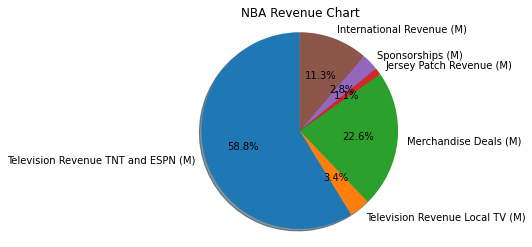

In [164]:
# NBA Income pie chart

import matplotlib.pyplot as plt

labels = ['Television Revenue TNT and ESPN (M)', 'Television Revenue Local TV (M)', 'Merchandise Deals (M)',
          'Jersey Patch Revenue (M)', 'Sponsorships (M)', 'International Revenue (M)']
sizes = [2.6, 0.15, 1.0, 0.05, 0.125, 0.5]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')
ax1.set_title("NBA Revenue Chart")
plt.show()

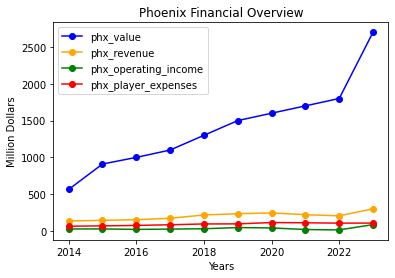

In [165]:
# Phx Financial Status
years = [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
phx_value = [565, 910, 1000, 1100, 1300, 1500, 1600, 1700, 1800, 2700]
phx_revenue = [137, 145, 154, 173, 218, 235, 246, 222, 206, 302]
phx_operating_income = [28.2, 28.2, 22, 26.3, 31, 47, 42, 20, 15, 87]
phx_player_expenses = [65, 70, 76, 85, 96, 97, 115, 112, 107, 108]

import matplotlib.pyplot as plt

#plot phx_value
plt.plot(years, phx_value, marker='o', color='blue', label='phx_value')

#plot phx_revenue
plt.plot(years, phx_revenue, marker='o', color='orange', label='phx_revenue')

#plot phx_operating_income
plt.plot(years, phx_operating_income, marker='o', color='green', label='phx_operating_income')

#plot phx_player_expenses
plt.plot(years, phx_player_expenses, marker='o', color='red', label='phx_player_expenses')

#add legend
plt.legend()

#add title
plt.title('Phoenix Financial Overview')

#add x and y labels
plt.xlabel('Years')
plt.ylabel('Million Dollars')

#show plot
plt.show()

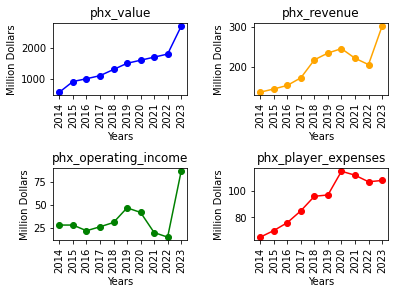

In [170]:
import matplotlib.pyplot as plt
import numpy as np

years = [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]

#plot phx_value
fig, axs = plt.subplots(2,2)
fig.subplots_adjust(hspace=1, wspace=0.5)

axs[0,0].plot(years, phx_value, marker='o', color='blue', label='phx_value')
axs[0,0].set_title('phx_value')
axs[0,0].set_xlabel('Years')
axs[0,0].set_ylabel('Million Dollars')
axs[0,0].set_xticks(years)
axs[0,0].tick_params(axis='x', rotation=90)

#plot phx_revenue
axs[0,1].plot(years, phx_revenue, marker='o', color='orange', label='phx_revenue')
axs[0,1].set_title('phx_revenue')
axs[0,1].set_xlabel('Years')
axs[0,1].set_ylabel('Million Dollars')
axs[0,1].set_xticks(years)
axs[0,1].tick_params(axis='x', rotation=90)

#plot phx_operating_income
axs[1,0].plot(years, phx_operating_income, marker='o', color='green', label='phx_operating_income')
axs[1,0].set_title('phx_operating_income')
axs[1,0].set_xlabel('Years')
axs[1,0].set_ylabel('Million Dollars')
axs[1,0].set_xticks(years)
axs[1,0].tick_params(axis='x', rotation=90)

#plot phx_player_expenses
axs[1,1].plot(years, phx_player_expenses, marker='o', color='red', label='phx_player_expenses')
axs[1,1].set_title('phx_player_expenses')
axs[1,1].set_xlabel('Years')
axs[1,1].set_ylabel('Million Dollars')
axs[1,1].set_xticks(years)
axs[1,1].tick_params(axis='x', rotation=90)

#show plot
plt.show()

In [ ]:
"""On September 21, Sarver announced he would begin the process of selling both the Phoenix Suns and the Phoenix Mercury.[98]
Sarver eventually accepted the purchase of both teams to United Wholesale Mortgage's CEO Mat Ishbia and his brother Justin 
for a record-high $4 billion purchasing price on December 20, 2022, with the move being made official on February 7, 2023.[99][100]
At 43 years old, Mat Ishbia became the youngest team owner in league history.[101]
Sarver has been criticized by current and former employees, agents, and rival executives for his overly hands-on approach to
business. He has been accused in one account "of being of an interventionist owner with more authority than expertise, 
a front office marred by instability, an understaffed scouting department, and a dated facility that isolates the 
decision-makers from the players and coaches".[22]
On November 4, 2021, Sarver and the Suns were the subject of a report written by Baxter Holmes on ESPN, which accused Sarver 
and members of the front office of racist and misogynistic behavior, including allegedly announcing his preference for 
extra-large condoms at a staff meeting.[23] The report was based on interviews with more than 70 former and current employees 
of the Suns
On September 13, 2022, the NBA fined Sarver the maximum $10 million and suspended him for one year in both the NBA and the WNBA
after an independent investigation determined that he said "nigger" at least five times in public – four of those being told by
subordinates afterward that he should not use the word – as well as conduct that included "unequal treatment of female employees;
sex-related statements and conduct; and harsh treatment of employees that on occasion constituted bullying."[29][30]
"""

In [ ]:
# the NBA makes an average of $1.2 million in gate revenue per regular season game and $2 million for each playoff game.